<a href="https://colab.research.google.com/github/nura6199/my-dissertation/blob/main/MHAbu3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Chronic_Kidney_Dsease_data.csv to Chronic_Kidney_Dsease_data.csv


In [3]:
# Function to plot confusion matrix with custom labels and colors
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Notckd', 'ckd']
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [4]:
# Load the dataset (adjust the path accordingly)
data = pd.read_csv('Chronic_Kidney_Dsease_data.csv')

In [5]:
# Drop non-predictive columns
data_clean = data.drop(columns=['PatientID', 'DoctorInCharge'])

In [6]:
# Split the data into features (X) and target (y)
X = data_clean.drop(columns=['Diagnosis'])
y = data_clean['Diagnosis']

In [7]:
# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [9]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Initialize individual models
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [12]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)
models['Random Forest'] = grid_search_rf.best_estimator_

In [13]:
# Train, predict, and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

In [14]:
# Predict the test set
y_pred = model.predict(X_test_scaled)

In [15]:
# Print classification report
print(f"Classification Report - {model_name}:\n")
print(classification_report(y_test, y_pred, target_names=['Notckd', 'ckd']))


Classification Report - Decision Tree:

              precision    recall  f1-score   support

      Notckd       0.85      0.89      0.87       452
         ckd       0.89      0.84      0.87       463

    accuracy                           0.87       915
   macro avg       0.87      0.87      0.87       915
weighted avg       0.87      0.87      0.87       915



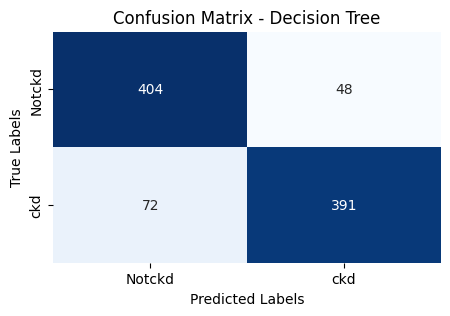

In [16]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, model_name)


In [17]:
# Stacking ensemble model
stacking_model = StackingClassifier(estimators=[
    ('knn', models['KNN']),
    ('rf', models['Random Forest']),
    ('svm', models['SVM']),
    ('nb', models['Naive Bayes']),
    ('dt', models['Decision Tree'])
], final_estimator=RandomForestClassifier(random_state=42))

stacking_model.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('rf',
                                RandomForestClassifier(max_depth=15,
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('nb', GaussianNB()),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

Classification Report - Stacking Model:

              precision    recall  f1-score   support

      Notckd       0.96      0.97      0.96       452
         ckd       0.97      0.96      0.97       463

    accuracy                           0.97       915
   macro avg       0.97      0.97      0.97       915
weighted avg       0.97      0.97      0.97       915



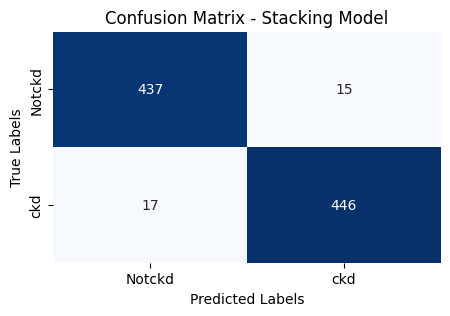

In [18]:
# Predict and evaluate stacking model
y_pred_stacking = stacking_model.predict(X_test_scaled)
print("Classification Report - Stacking Model:\n")
print(classification_report(y_test, y_pred_stacking, target_names=['Notckd', 'ckd']))
plot_confusion_matrix(y_test, y_pred_stacking, "Hybrid Model")


In [21]:
# Evaluate hybrid ensemble model with weighted voting
hybrid_model_weighted = VotingClassifier(estimators=[
    ('knn', models['KNN']),
    ('rf', models['Random Forest']),
    ('svm', models['SVM']),
    ('nb', models['Naive Bayes']),
    ('dt', models['Decision Tree'])
], voting='soft', weights=[1, 2, 2, 1, 1])


In [22]:
# Train the hybrid model
hybrid_model_weighted.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('rf',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('nb', GaussianNB()),
                             ('dt', DecisionTreeClassifier(random_state=42))],
                 voting='soft', weights=[1, 2, 2, 1, 1])

In [23]:
# Predict using the hybrid model
y_pred_hybrid = hybrid_model_weighted.predict(X_test_scaled)

Classification Report - Weighted Hybrid Model:

              precision    recall  f1-score   support

      Notckd       0.94      0.96      0.95       452
         ckd       0.96      0.94      0.95       463

    accuracy                           0.95       915
   macro avg       0.95      0.95      0.95       915
weighted avg       0.95      0.95      0.95       915



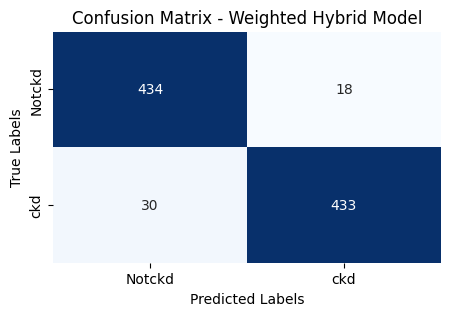

In [24]:
# Print classification report for hybrid model
print("Classification Report - Weighted Hybrid Model:\n")
print(classification_report(y_test, y_pred_hybrid, target_names=['Notckd', 'ckd']))
plot_confusion_matrix(y_test, y_pred_hybrid, "Weighted Hybrid Model")

In [25]:
# Cross-validation score for hybrid model
cv_scores = cross_val_score(hybrid_model_weighted, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean() * 100:.2f}%")

Cross-validation accuracy: 93.95%


Classification Report - KNN:

              precision    recall  f1-score   support

      Notckd       0.59      1.00      0.74       452
         ckd       1.00      0.32      0.48       463

    accuracy                           0.66       915
   macro avg       0.79      0.66      0.61       915
weighted avg       0.80      0.66      0.61       915



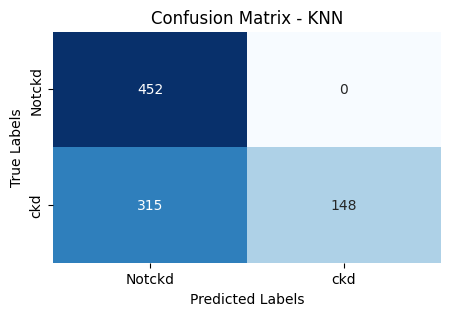

Confusion Matrix - KNN:
[[452   0]
 [315 148]]

Classification Report - Random Forest:

              precision    recall  f1-score   support

      Notckd       0.96      0.96      0.96       452
         ckd       0.96      0.96      0.96       463

    accuracy                           0.96       915
   macro avg       0.96      0.96      0.96       915
weighted avg       0.96      0.96      0.96       915



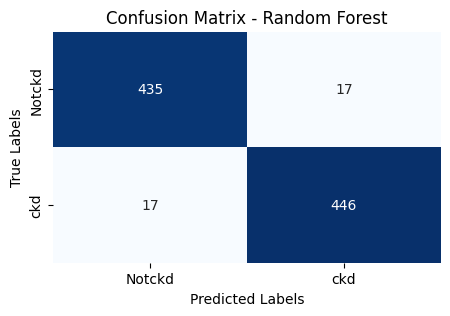

Confusion Matrix - Random Forest:
[[435  17]
 [ 17 446]]

Classification Report - SVM:

              precision    recall  f1-score   support

      Notckd       0.97      0.94      0.96       452
         ckd       0.95      0.97      0.96       463

    accuracy                           0.96       915
   macro avg       0.96      0.96      0.96       915
weighted avg       0.96      0.96      0.96       915



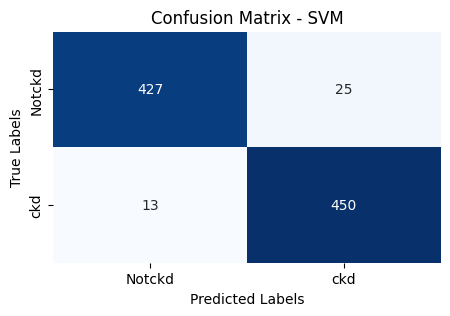

Confusion Matrix - SVM:
[[427  25]
 [ 13 450]]

Classification Report - Naive Bayes:

              precision    recall  f1-score   support

      Notckd       0.87      0.90      0.88       452
         ckd       0.90      0.87      0.88       463

    accuracy                           0.88       915
   macro avg       0.88      0.88      0.88       915
weighted avg       0.88      0.88      0.88       915



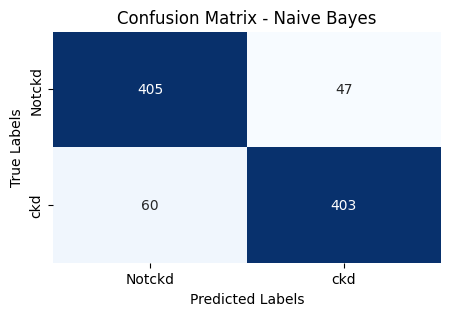

Confusion Matrix - Naive Bayes:
[[405  47]
 [ 60 403]]

Classification Report - Decision Tree:

              precision    recall  f1-score   support

      Notckd       0.85      0.89      0.87       452
         ckd       0.89      0.84      0.87       463

    accuracy                           0.87       915
   macro avg       0.87      0.87      0.87       915
weighted avg       0.87      0.87      0.87       915



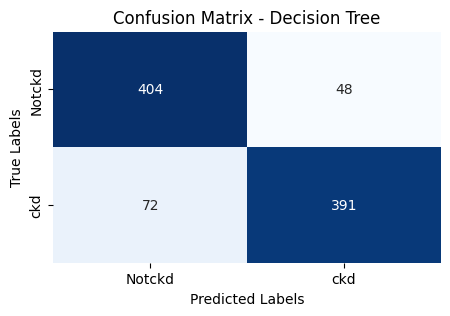

Confusion Matrix - Decision Tree:
[[404  48]
 [ 72 391]]



In [26]:
# Train, predict, and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict the test set
    y_pred = model.predict(X_test_scaled)

    # Generate classification report
    class_report = classification_report(y_test, y_pred, target_names=['Notckd', 'ckd'], output_dict=True)

    # Display classification report
    print(f"Classification Report - {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Notckd', 'ckd']))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix - {model_name}:\n{cm}\n")


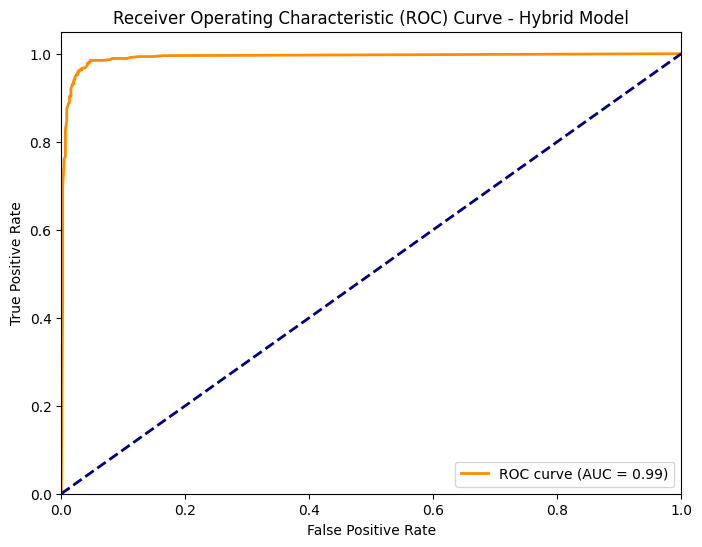

AUC Score: 0.9918


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'ckd' is the positive class and is labeled as 1
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Hybrid Model')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f"AUC Score: {roc_auc:.4f}")